# First pass at developing the TTS pipeline

Using off the shelf hugging-face models to build the transcription -> translation -> summarisation pipeline.

### Lets start with a transcription model

Looks like the `openai/whisper-small` model would be appropriate, it does French to French transcription.

In [1]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import Audio, load_dataset

In [2]:
# Loade model and processor
transcription_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
transcription_model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-small"
)
forced_decoder_ids = transcription_processor.get_decoder_prompt_ids(
    language="french", task="transcribe"
)

In [3]:
# load streaming dataset and read first audio sample
ds = load_dataset(
    "facebook/multilingual_librispeech", "french", split="test", streaming=True
)

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

In [4]:
next(iter(ds))

{'audio': {'path': '1406_1028_000000.opus',
  'array': array([ 3.16312944e-04,  2.51584337e-04,  1.96699897e-04, ...,
          2.33122555e-04, -8.31385187e-05, -1.13553528e-04]),
  'sampling_rate': 16000},
 'original_path': 'http://www.archive.org/download/les1001nuits_tome1_0711_librivox/1001nuits1_010_galland_64kb.mp3',
 'begin_time': 210.62,
 'end_time': 227.11,
 'transcript': "pendant le second siècle je fis serment d'ouvrir tous les trésors de la terre à quiconque me mettrait en liberté mais je ne fus pas plus heureux dans le troisième je promis de faire puissant monarque mon libérateur d'être toujours près de lui en esprit",
 'audio_duration': 16.49000000000001,
 'speaker_id': '1406',
 'chapter_id': '1028',
 'file': '1406_1028_000000.opus',
 'id': '1406_1028_000000'}

In [7]:
new_ds = ds.cast_column("audio", Audio(sampling_rate=16_000))
input_speech = next(iter(new_ds))["audio"]
input_features = transcription_processor(
    input_speech["array"],
    sampling_rate=input_speech["sampling_rate"],
    return_tensors="pt",
).input_features

In [8]:
import matplotlib.pyplot as plt

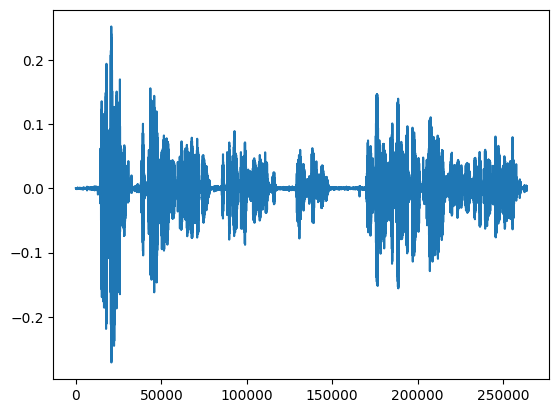

In [11]:
plt.plot(input_speech["array"])

In [14]:
# generate token ids
predicted_ids = transcription_model.generate(
    input_features, forced_decoder_ids=forced_decoder_ids
)

In [15]:
# decode token ids to text
transcription = transcription_processor.batch_decode(predicted_ids)
transcription

["<|startoftranscript|><|fr|><|transcribe|><|notimestamps|> Pendant le second siècle, je fis serment d'ouvrir tous les trésors de la terre, à qui compte-me mettre en liberté. Mais je ne fus pas plus heureux. Dans le troisième, je promis de faire puissant mon arc, mon libérateur, d'être toujours près de lui en esprit."]

In [16]:
# transcription without special characters
transcription = transcription_processor.batch_decode(
    predicted_ids, skip_special_tokens=True
)
transcription

[" Pendant le second siècle, je fis serment d'ouvrir tous les trésors de la terre, à qui compte-me mettre en liberté. Mais je ne fus pas plus heureux. Dans le troisième, je promis de faire puissant mon arc, mon libérateur, d'être toujours près de lui en esprit."]

### And now onto translation

Should be relatively straightforward

In [1]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

In [17]:
# load model and tokenizer
translation_model = MBartForConditionalGeneration.from_pretrained(
    "facebook/mbart-large-50-many-to-many-mmt"
)
translation_tokenizer = MBart50TokenizerFast.from_pretrained(
    "facebook/mbart-large-50-many-to-many-mmt"
)

/Users/edable-heath/Documents/ARC-SPICE/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
# translate from french to english
translation_tokenizer.src_lang = "fr_XX"
encode_fr = translation_tokenizer(transcription, return_tensors="pt")
generated_tokens = translation_model.generate(
    **encode_fr, forced_bos_token_id=translation_tokenizer.lang_code_to_id["en_XX"]
)

In [28]:
translation = translation_tokenizer.batch_decode(
    generated_tokens, skip_special_tokens=True
)
translation

['In the second century, I swore to open all the treasures of the earth, to whom I was about to release, but I was no happier. In the third, I promised to make my bow, my liberator, powerful, to be always close to him in mind.']

### And Finally: Summarisation

Lets use the facebook model

In [22]:
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

/Users/edable-heath/Documents/ARC-SPICE/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [23]:
article = """
Rail workers have voted to accept pay offers by train companies and Network Rail, reducing the prospect of a repeat of the national strikes that have caused misery for passengers over the last two years.

Members of the National Union of Rail, Maritime and Transport Workers (RMT) voted overwhelmingly to support the pay offers that will result in increases of more than 4 percent over the next two years.

The RMT said the ballot result meant that the long-running national dispute was now over and the outcome reflected collective efforts to defend jobs and pay conditions from the attacks of private contractors and the previous Conservative government.

LNER trains at King's Cross station in London

The RMT held more than 30 days of industrial action since June 2022 over a previous pay dispute with Network Rail and rail operators.

A deal was agreed in March last year with Network Rail, while its deal with operators was concluded in November last year.

The latest pay deal will lead to union members at Network Rail, who are largely maintenance staff and signallers, receiving a 4.5 percent increase this year. Almost 89 percent of those members who voted were favour of the deal.

The agreement with operators, which covers train crew and ticket office staff, will lead to a 4.75 percent backdated increase on last year’s pay, with a 4.5 percent rise for the current financial year. The ballot featured 99 percent of voting members voting in favour of the deal.

In a statement, the RMT said: “We thank our members for their efforts during this long but successful campaign.

“Their resolve has been essential in navigating the challenges posed during negotiations and in particular the previous Tory government’s refusal to negotiate in good faith, alongside relentless attacks by sections of the media and the employers.

“RMT remains focused and committed to supporting public ownership as a path to building a stronger future for the rail industry for both workers and passengers.”

The transport secretary, Louise Haigh, said: “This is a necessary step towards fixing our railways and getting the country moving.


“It will ensure a more reliable service by helping to protect passengers from national strikes, and crucially, it clears the way for vital reform and modernising working practices to ensure a better performing railway for everyone.

“This Labour government won’t make the same mistake as the Conservatives who deliberately prolonged rail strikes and cost the economy more than £1bn.”

Last week, train drivers who are members of the Aslef union voted to back a pay deal.

The decision came after drivers had taken 18 days of strike action since July 2022, resulting in a near-complete shutdown of English lines and some cross-border services, as well as a run of overtime bans that caused widespread disruption.


"""
summarizer(
    article,
    # max_length=len(article.split()) // 2,
    # min_length=len(article.split()) // 5,
    # do_sample=False,
)

[{'summary_text': 'National Union of Rail, Maritime and Transport Workers (RMT) voted overwhelmingly to support the pay offers that will result in increases of more than 4 percent over the next two years. RMT held more than 30 days of industrial action since June 2022 over a previous pay dispute with Network Rail and rail operators.'}]

In [36]:
len(article.split())

95

Summariser seems to work, but only for sufficiently long examples, which makes sense. Otherwise it just picks up the first part of the text. Need to find some french recordings on sufficient length.

## Can this be tied together in one pipeline structure?

This will make generalisation easier.

In [31]:
from transformers import pipeline

# transcription
asr = pipeline("automatic-speech-recognition", model="openai/whisper-small")
transcription = asr(input_speech["array"])
print(f"The transcription is: \n {transcription['text']}")

# translation
trltr = pipeline(
    "translation_fr_to_en", model="facebook/mbart-large-50-many-to-many-mmt"
)
translation = trltr(transcription["text"])
print(f"The translation is: \n {translation[0]['translation_text']}")

# summarisation
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
summary = summarizer(translation[0]["translation_text"])
print(f"The summary is: \n {summary[0]['summary_text']}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


The transcription is: 
  Pendant le second siècle, je fis serment d'ouvrir tous les trésors de la terre, à qui compte-me mettre en liberté. Mais je ne fus pas plus heureux. Dans le troisième, je promis de faire puissant mon arc, mon libérateur, d'être toujours près de lui en esprit.


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


The translation is: 
 en the second century, I made a vow to open all the treasures of the earth, to whom I intend to release. But I was no happier. In the third, I promised to make my bow, my liberal, powerful, to be always close to him in mind.


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 142, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


The summary is: 
 In the second century, I made a vow to open all the treasures of the earth, to whom I intend to release. But I was no happier. In the third, I promised to make my bow, my liberal, powerful, to be always close to him in mind.


## Putting it all together into a single script

In [39]:
from transformers import (
    pipeline,
)


class TTSpipeline:
    """
    Class for the transcription, translation, summarisation pipeline.

    pars:
        - {'top_level_task': {'specific_task': str, 'model_name': str}}
    """

    def __init__(self, pars) -> None:
        self.pars = pars
        self.transcriber = pipeline(
            pars["transcriber"]["specific_task"], pars["transcriber"]["model"]
        )
        self.translator = pipeline(
            pars["translator"]["specific_task"], pars["translator"]["model"]
        )
        self.summariser = pipeline(
            pars["summariser"]["specific_task"], pars["summariser"]["model"]
        )
        self.results = {}

    def print_pipeline(self):
        """Print the models in the pipeline"""
        print(f"Transcriber model: {self.pars['transcriber']['model']}")
        print(f"Translator model: {self.pars['translator']['model']}")
        print(f"Summariser model: {self.pars['summariser']['model']}")

    def run_pipeline(self, x):
        """Run the pipeline on an input x"""
        transcription = self.transcriber(x)
        self.results["transcription"] = transcription["text"]
        translation = self.translator(transcription["text"])
        self.results["translation"] = translation[0]["translation_text"]
        summarisation = self.summariser(translation[0]["translation_text"])
        self.results["summarisation"] = summarisation[0]["summary_text"]

    def print_results(self):
        """Print the results for quick scanning"""
        for key, val in self.results.items():
            print(f"{key} result is: \n {val}")

In [40]:
TTS_pars = {
    "transcriber": {
        "specific_task": "automatic-speech-recognition",
        "model": "openai/whisper-small",
    },
    "translator": {
        "specific_task": "translation_fr_to_en",
        "model": "facebook/mbart-large-50-many-to-many-mmt",
    },
    "summariser": {
        "specific_task": "summarization",
        "model": "facebook/bart-large-cnn",
    },
}

TTS_pipeline = TTSpipeline(TTS_pars)

TTS_pipeline.print_pipeline()

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/edable-heath/Documents/ARC-SPICE/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Transcriber model: openai/whisper-small
Translator model: facebook/mbart-large-50-many-to-many-mmt
Summariser model: facebook/bart-large-cnn


In [41]:
# lets give it some data
from datasets import Audio, load_dataset

ds = load_dataset(
    "facebook/multilingual_librispeech", "french", split="test", streaming=True
)
ds = ds.cast_column("audio", Audio(sampling_rate=16_000))
input_speech = next(iter(ds))["audio"]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/34 [00:00<?, ?it/s]

In [42]:
TTS_pipeline.run_pipeline(input_speech["array"])

/Users/edable-heath/Documents/ARC-SPICE/.venv/lib/python3.11/site-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Your max_length is set to 142, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


In [43]:
TTS_pipeline.print_results()

transcription result is: 
  Pendant le second siècle, je fis serment d'ouvrir tous les trésors de la terre, à qui compte-me mettre en liberté. Mais je ne fus pas plus heureux. Dans le troisième, je promis de faire puissant mon arc, mon libérateur, d'être toujours près de lui en esprit.
translation result is: 
 en the second century, I made a vow to open all the treasures of the earth, to whom I intend to release. But I was no happier. In the third, I promised to make my bow, my liberal, powerful, to be always close to him in mind.
summarisation result is: 
 In the second century, I made a vow to open all the treasures of the earth, to whom I intend to release. But I was no happier. In the third, I promised to make my bow, my liberal, powerful, to be always close to him in mind.
